c:\Users\Alpha\Desktop\Project_in_secure_ML\pytorch_env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alpha\AppData\Local\Temp\ipykernel_22876\2774206730.py:118: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=85, p=0.2)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

Epoch 1: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s, Loss=5.83, Acc=5.47%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 2: 100%|██████████| 15/15 [00:00<00:00, 17.24it/s, Loss=5.49, Acc=9.77%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 18.38it/s, Loss=5.33, Acc=11.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 19.85it/s, Loss=4.9, Acc=14.59%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.33      0.20      0.25         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.71      0.42      0.53        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 5: 100%|██████████| 15/15 [00:00<00:00, 19.17it/s, Loss=4.7, Acc=17.93%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.60      0.50      0.55        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 18.85it/s, Loss=4.59, Acc=20.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       1.00      0.17      0.29         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.50      0.20      0.29         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.50      0.50      0.50        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 7: 100%|██████████| 15/15 [00:00<00:00, 17.38it/s, Loss=4.72, Acc=22.86%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.50      0.17      0.25         6
             Alvaro_Uribe       0.14      0.40      0.21         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.50      0.40      0.44         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.47      0.75      0.58        12
    Arnold_Schwarzenegger       0.25      0.33      0.29         6
     Atal_Bihari_Vajpay

Epoch 8: 100%|██████████| 15/15 [00:00<00:00, 18.37it/s, Loss=4.16, Acc=25.44%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       1.00      0.17      0.29         6
             Alvaro_Uribe       0.20      0.60      0.30         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.60      0.60      0.60         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.45      0.75      0.56        12
    Arnold_Schwarzenegger       0.18      0.33      0.24         6
     Atal_Bihari_Vajpay

Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 21.98it/s, Loss=4.04, Acc=27.46%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       1.00      0.17      0.29         6
             Alvaro_Uribe       0.17      0.20      0.18         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       1.00      0.60      0.75         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.35      0.75      0.47        12
    Arnold_Schwarzenegger       0.50      0.33      0.40         6
     Atal_Bihari_Vajpay

Epoch 10: 100%|██████████| 15/15 [00:00<00:00, 16.34it/s, Loss=3.57, Acc=31.05%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       1.00      0.33      0.50         6
             Alvaro_Uribe       0.30      0.60      0.40         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.47      0.75      0.58        12
    Arnold_Schwarzenegger       0.20      0.33      0.25         6
     Atal_Bihari_Vajpay

Epoch 11: 100%|██████████| 15/15 [00:00<00:00, 19.72it/s, Loss=3.46, Acc=35.65%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.50      0.83      0.62         6
             Alvaro_Uribe       0.30      0.60      0.40         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.36      0.80      0.50         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.34      0.92      0.50        12
    Arnold_Schwarzenegger       0.25      0.67      0.36         6
     Atal_Bihari_Vajpay

Epoch 12: 100%|██████████| 15/15 [00:00<00:00, 19.70it/s, Loss=4.31, Acc=38.64%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.46      1.00      0.63         6
             Alvaro_Uribe       0.23      0.60      0.33         5
          Amelie_Mauresmo       1.00      0.67      0.80         3
             Andre_Agassi       0.44      0.80      0.57         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 13: 100%|██████████| 15/15 [00:00<00:00, 21.38it/s, Loss=3.14, Acc=42.94%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.43      1.00      0.60         6
             Alvaro_Uribe       0.23      0.60      0.33         5
          Amelie_Mauresmo       0.67      0.67      0.67         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.61      0.92      0.73        12
    Arnold_Schwarzenegger       0.45      0.83      0.59         6
     Atal_Bihari_Vajpay

Epoch 14: 100%|██████████| 15/15 [00:00<00:00, 20.11it/s, Loss=2.67, Acc=49.17%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.33      0.50         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.35      1.00      0.52         6
             Alvaro_Uribe       0.25      0.60      0.35         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.45      1.00      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 15: 100%|██████████| 15/15 [00:00<00:00, 15.98it/s, Loss=2.79, Acc=52.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.33      0.50         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.40      1.00      0.57         6
             Alvaro_Uribe       0.30      0.60      0.40         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      0.50      0.67         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.56      0.83      0.67         6
     Atal_Bihari_Vajpay

Epoch 16: 100%|██████████| 15/15 [00:00<00:00, 21.22it/s, Loss=3.91, Acc=57.96%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.35      1.00      0.52         6
             Alvaro_Uribe       0.43      0.60      0.50         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.56      0.83      0.67         6
     Atal_Bihari_Vajpay

Epoch 17: 100%|██████████| 15/15 [00:00<00:00, 21.19it/s, Loss=2.19, Acc=60.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.50      1.00      0.67         6
             Alvaro_Uribe       0.38      0.60      0.46         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 18: 100%|██████████| 15/15 [00:00<00:00, 18.96it/s, Loss=2.18, Acc=61.58%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       0.38      0.60      0.46         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 19: 100%|██████████| 15/15 [00:00<00:00, 18.21it/s, Loss=1.84, Acc=70.01%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.55      1.00      0.71         6
             Alvaro_Uribe       0.44      0.80      0.57         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 20: 100%|██████████| 15/15 [00:00<00:00, 20.41it/s, Loss=1.84, Acc=71.35%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.46      1.00      0.63         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 21: 100%|██████████| 15/15 [00:00<00:00, 19.82it/s, Loss=1.64, Acc=74.26%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.55      1.00      0.71         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 22: 100%|██████████| 15/15 [00:00<00:00, 20.64it/s, Loss=1.69, Acc=80.41%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.33      0.50      0.40         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 23: 100%|██████████| 15/15 [00:00<00:00, 20.76it/s, Loss=1.62, Acc=83.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s, Loss=1.49, Acc=81.44%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 25: 100%|██████████| 15/15 [00:00<00:00, 21.50it/s, Loss=1.37, Acc=86.34%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.56      0.83      0.67         6
     Atal_Bihari_Vajpay

Epoch 26: 100%|██████████| 15/15 [00:00<00:00, 20.72it/s, Loss=1.38, Acc=84.71%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 27: 100%|██████████| 15/15 [00:00<00:00, 21.03it/s, Loss=1.28, Acc=89.52%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.25      0.50      0.33         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.33      0.33         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 28: 100%|██████████| 15/15 [00:00<00:00, 18.82it/s, Loss=1.19, Acc=90.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 29: 100%|██████████| 15/15 [00:00<00:00, 23.17it/s, Loss=1.22, Acc=90.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.90      0.75      0.82        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 30: 100%|██████████| 15/15 [00:00<00:00, 22.96it/s, Loss=1.31, Acc=92.03%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 31: 100%|██████████| 15/15 [00:00<00:00, 19.94it/s, Loss=1.2, Acc=89.22%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.75      0.86        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 32: 100%|██████████| 15/15 [00:00<00:00, 21.82it/s, Loss=1.16, Acc=84.05%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 33: 100%|██████████| 15/15 [00:00<00:00, 22.65it/s, Loss=2.32, Acc=88.14%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 34: 100%|██████████| 15/15 [00:00<00:00, 23.84it/s, Loss=1.19, Acc=85.25%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 35: 100%|██████████| 15/15 [00:00<00:00, 21.09it/s, Loss=1.12, Acc=94.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 36: 100%|██████████| 15/15 [00:00<00:00, 22.85it/s, Loss=1.05, Acc=89.09%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.67      1.00      0.80        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 37: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s, Loss=1.13, Acc=95.13%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 38: 100%|██████████| 15/15 [00:00<00:00, 23.78it/s, Loss=1.17, Acc=87.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 39: 100%|██████████| 15/15 [00:00<00:00, 23.31it/s, Loss=1.09, Acc=90.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      0.80      0.89         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.90      0.75      0.82        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 40: 100%|██████████| 15/15 [00:00<00:00, 18.92it/s, Loss=1.05, Acc=92.46%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.14      0.50      0.22         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.73      0.92      0.81        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 41: 100%|██████████| 15/15 [00:00<00:00, 22.98it/s, Loss=1.08, Acc=95.51%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 42: 100%|██████████| 15/15 [00:00<00:00, 23.30it/s, Loss=1.01, Acc=93.71%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       1.00      1.00      1.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.71      0.83      0.77        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 43: 100%|██████████| 15/15 [00:00<00:00, 22.56it/s, Loss=1.08, Acc=92.98%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.40      0.80      0.53         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 44: 100%|██████████| 15/15 [00:00<00:00, 25.44it/s, Loss=1.07, Acc=94.29%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 45: 100%|██████████| 15/15 [00:00<00:00, 22.84it/s, Loss=2.37, Acc=97.31%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.75      1.00      0.86         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 46: 100%|██████████| 15/15 [00:00<00:00, 18.36it/s, Loss=1.07, Acc=92.08%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 47: 100%|██████████| 15/15 [00:00<00:00, 20.99it/s, Loss=1.01, Acc=90.18%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 48: 100%|██████████| 15/15 [00:00<00:00, 22.56it/s, Loss=0.99, Acc=99.13%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 49: 100%|██████████| 15/15 [00:00<00:00, 21.02it/s, Loss=1.04, Acc=91.89%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.55      1.00      0.71         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 50: 100%|██████████| 15/15 [00:00<00:00, 23.91it/s, Loss=1, Acc=98.88%]   



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 51: 100%|██████████| 15/15 [00:00<00:00, 25.06it/s, Loss=0.976, Acc=95.02%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.50      1.00      0.67         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 52: 100%|██████████| 15/15 [00:00<00:00, 21.05it/s, Loss=1, Acc=97.31%]    



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 53: 100%|██████████| 15/15 [00:00<00:00, 20.57it/s, Loss=1.03, Acc=88.98%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.82      0.75      0.78        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 54: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s, Loss=1.01, Acc=99.07%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 55: 100%|██████████| 15/15 [00:00<00:00, 21.87it/s, Loss=0.959, Acc=94.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 56: 100%|██████████| 15/15 [00:00<00:00, 23.76it/s, Loss=1.01, Acc=95.21%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.75      0.86        12
    Arnold_Schwarzenegger       0.50      0.83      0.62         6
     Atal_Bihari_Vajpay

Epoch 57: 100%|██████████| 15/15 [00:00<00:00, 22.25it/s, Loss=0.975, Acc=97.55%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 58: 100%|██████████| 15/15 [00:00<00:00, 24.73it/s, Loss=0.979, Acc=95.51%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 59: 100%|██████████| 15/15 [00:00<00:00, 22.89it/s, Loss=0.995, Acc=93.69%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 60: 100%|██████████| 15/15 [00:00<00:00, 22.55it/s, Loss=2.2, Acc=98.42%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 61: 100%|██████████| 15/15 [00:00<00:00, 20.05it/s, Loss=0.938, Acc=98.04%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.38      0.60      0.46         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 62: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s, Loss=0.971, Acc=97.66%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 63: 100%|██████████| 15/15 [00:00<00:00, 21.56it/s, Loss=0.968, Acc=99.62%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 64: 100%|██████████| 15/15 [00:00<00:00, 17.23it/s, Loss=1.77, Acc=97.47%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.36      1.00      0.53         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 65: 100%|██████████| 15/15 [00:00<00:00, 24.29it/s, Loss=0.939, Acc=94.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 66: 100%|██████████| 15/15 [00:00<00:00, 20.33it/s, Loss=0.957, Acc=98.04%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 67: 100%|██████████| 15/15 [00:00<00:00, 22.16it/s, Loss=0.922, Acc=99.62%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 68: 100%|██████████| 15/15 [00:00<00:00, 22.65it/s, Loss=0.918, Acc=96.49%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 69: 100%|██████████| 15/15 [00:00<00:00, 21.97it/s, Loss=1.79, Acc=95.92%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 70: 100%|██████████| 15/15 [00:00<00:00, 20.67it/s, Loss=0.909, Acc=99.92%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 71: 100%|██████████| 15/15 [00:00<00:00, 23.10it/s, Loss=0.902, Acc=98.23%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 72: 100%|██████████| 15/15 [00:00<00:00, 21.65it/s, Loss=0.907, Acc=96.76%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 73: 100%|██████████| 15/15 [00:00<00:00, 23.50it/s, Loss=0.9, Acc=95.78%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 74: 100%|██████████| 15/15 [00:00<00:00, 24.41it/s, Loss=0.902, Acc=97.50%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 75: 100%|██████████| 15/15 [00:00<00:00, 23.44it/s, Loss=1.62, Acc=95.84%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 76: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s, Loss=0.893, Acc=98.64%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 77: 100%|██████████| 15/15 [00:00<00:00, 22.96it/s, Loss=0.932, Acc=96.79%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 78: 100%|██████████| 15/15 [00:00<00:00, 22.98it/s, Loss=1.71, Acc=92.38%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.75      0.86        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 79: 100%|██████████| 15/15 [00:00<00:00, 22.94it/s, Loss=0.893, Acc=98.83%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 80: 100%|██████████| 15/15 [00:00<00:00, 21.41it/s, Loss=0.884, Acc=98.67%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 81: 100%|██████████| 15/15 [00:00<00:00, 21.44it/s, Loss=0.884, Acc=99.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.67      0.67      0.67         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 82: 100%|██████████| 15/15 [00:00<00:00, 22.70it/s, Loss=0.892, Acc=97.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 83: 100%|██████████| 15/15 [00:00<00:00, 22.26it/s, Loss=0.881, Acc=98.67%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 84: 100%|██████████| 15/15 [00:00<00:00, 20.76it/s, Loss=0.886, Acc=99.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 85: 100%|██████████| 15/15 [00:00<00:00, 20.14it/s, Loss=0.896, Acc=94.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.60      1.00      0.75         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 86: 100%|██████████| 15/15 [00:00<00:00, 21.84it/s, Loss=0.88, Acc=96.98%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 87: 100%|██████████| 15/15 [00:00<00:00, 22.21it/s, Loss=0.922, Acc=98.50%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.33      0.50      0.40         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 88: 100%|██████████| 15/15 [00:00<00:00, 23.35it/s, Loss=1.44, Acc=99.56%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.56      0.83      0.67         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 89: 100%|██████████| 15/15 [00:00<00:00, 22.94it/s, Loss=0.877, Acc=96.30%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.50      0.80      0.62         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 90: 100%|██████████| 15/15 [00:00<00:00, 20.99it/s, Loss=0.877, Acc=99.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 91: 100%|██████████| 15/15 [00:00<00:00, 20.84it/s, Loss=0.868, Acc=98.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.33      0.50      0.40         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 92: 100%|██████████| 15/15 [00:00<00:00, 22.16it/s, Loss=0.865, Acc=99.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 93: 100%|██████████| 15/15 [00:00<00:00, 22.60it/s, Loss=0.868, Acc=98.29%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.33      0.50      0.40         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 94: 100%|██████████| 15/15 [00:00<00:00, 20.12it/s, Loss=0.872, Acc=96.84%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.77      0.83      0.80        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 95: 100%|██████████| 15/15 [00:00<00:00, 20.45it/s, Loss=0.869, Acc=99.86%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 96: 100%|██████████| 15/15 [00:00<00:00, 23.50it/s, Loss=0.871, Acc=96.93%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 97: 100%|██████████| 15/15 [00:00<00:00, 23.40it/s, Loss=0.866, Acc=98.20%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 98: 100%|██████████| 15/15 [00:00<00:00, 23.33it/s, Loss=0.87, Acc=98.07%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 20.14it/s, Loss=0.883, Acc=98.78%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.67      0.57         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 100: 100%|██████████| 15/15 [00:00<00:00, 19.54it/s, Loss=1.47, Acc=99.62%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.30      0.60      0.40         5
          Amelie_Mauresmo       0.60      1.00      0.75         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 101: 100%|██████████| 15/15 [00:00<00:00, 19.96it/s, Loss=1.7, Acc=97.52%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 102: 100%|██████████| 15/15 [00:00<00:00, 22.36it/s, Loss=1.32, Acc=98.97%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 103: 100%|██████████| 15/15 [00:00<00:00, 23.15it/s, Loss=0.88, Acc=99.02%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 104: 100%|██████████| 15/15 [00:00<00:00, 19.61it/s, Loss=0.862, Acc=98.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 105: 100%|██████████| 15/15 [00:00<00:00, 23.03it/s, Loss=0.872, Acc=98.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 106: 100%|██████████| 15/15 [00:00<00:00, 20.43it/s, Loss=0.862, Acc=99.21%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 107: 100%|██████████| 15/15 [00:00<00:00, 21.02it/s, Loss=0.867, Acc=97.93%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 108: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s, Loss=0.863, Acc=98.99%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 109: 100%|██████████| 15/15 [00:00<00:00, 21.22it/s, Loss=0.86, Acc=98.26%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 110: 100%|██████████| 15/15 [00:00<00:00, 20.93it/s, Loss=0.861, Acc=99.40%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 111: 100%|██████████| 15/15 [00:00<00:00, 20.73it/s, Loss=0.859, Acc=99.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 112: 100%|██████████| 15/15 [00:00<00:00, 21.86it/s, Loss=0.854, Acc=98.34%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 113: 100%|██████████| 15/15 [00:00<00:00, 20.33it/s, Loss=0.862, Acc=99.18%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 114: 100%|██████████| 15/15 [00:00<00:00, 22.20it/s, Loss=0.861, Acc=99.29%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.75      0.86        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 115: 100%|██████████| 15/15 [00:00<00:00, 21.35it/s, Loss=0.855, Acc=99.13%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 116: 100%|██████████| 15/15 [00:00<00:00, 21.92it/s, Loss=0.86, Acc=100.00%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 117: 100%|██████████| 15/15 [00:00<00:00, 22.41it/s, Loss=0.854, Acc=99.29%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 118: 100%|██████████| 15/15 [00:00<00:00, 19.84it/s, Loss=0.861, Acc=99.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 119: 100%|██████████| 15/15 [00:00<00:00, 20.61it/s, Loss=0.857, Acc=97.69%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 120: 100%|██████████| 15/15 [00:00<00:00, 20.20it/s, Loss=0.863, Acc=100.00%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 121: 100%|██████████| 15/15 [00:00<00:00, 20.50it/s, Loss=0.857, Acc=97.82%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 122: 100%|██████████| 15/15 [00:00<00:00, 22.39it/s, Loss=1.3, Acc=99.73%]   



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 123: 100%|██████████| 15/15 [00:00<00:00, 20.31it/s, Loss=0.857, Acc=99.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 124: 100%|██████████| 15/15 [00:00<00:00, 20.86it/s, Loss=0.854, Acc=99.37%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 125: 100%|██████████| 15/15 [00:00<00:00, 20.78it/s, Loss=0.851, Acc=99.46%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 126: 100%|██████████| 15/15 [00:00<00:00, 20.93it/s, Loss=1.28, Acc=98.97%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 127: 100%|██████████| 15/15 [00:00<00:00, 20.83it/s, Loss=1.26, Acc=98.48%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.75      0.86        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 128: 100%|██████████| 15/15 [00:00<00:00, 23.10it/s, Loss=0.852, Acc=99.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 129: 100%|██████████| 15/15 [00:00<00:00, 19.80it/s, Loss=1.34, Acc=95.02%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 130: 100%|██████████| 15/15 [00:00<00:00, 22.80it/s, Loss=0.851, Acc=98.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       0.50      1.00      0.67         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 131: 100%|██████████| 15/15 [00:00<00:00, 21.61it/s, Loss=0.859, Acc=99.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 132: 100%|██████████| 15/15 [00:00<00:00, 22.82it/s, Loss=0.853, Acc=99.27%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 133: 100%|██████████| 15/15 [00:00<00:00, 23.72it/s, Loss=0.852, Acc=99.95%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 134: 100%|██████████| 15/15 [00:00<00:00, 22.77it/s, Loss=1.2, Acc=98.56%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.77      0.83      0.80        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 135: 100%|██████████| 15/15 [00:00<00:00, 22.26it/s, Loss=0.85, Acc=99.59%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.75      1.00      0.86         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.77      0.83      0.80        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 136: 100%|██████████| 15/15 [00:00<00:00, 23.53it/s, Loss=1.16, Acc=98.75%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 137: 100%|██████████| 15/15 [00:00<00:00, 22.49it/s, Loss=0.852, Acc=100.00%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 138: 100%|██████████| 15/15 [00:00<00:00, 22.99it/s, Loss=0.856, Acc=99.43%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 139: 100%|██████████| 15/15 [00:00<00:00, 20.81it/s, Loss=0.849, Acc=99.56%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       0.75      1.00      0.86         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 140: 100%|██████████| 15/15 [00:00<00:00, 22.36it/s, Loss=0.864, Acc=97.09%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.50      0.50      0.50         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 141: 100%|██████████| 15/15 [00:00<00:00, 21.59it/s, Loss=0.85, Acc=97.47%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      1.00      1.00         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 142: 100%|██████████| 15/15 [00:00<00:00, 22.46it/s, Loss=0.856, Acc=98.99%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 143: 100%|██████████| 15/15 [00:00<00:00, 23.23it/s, Loss=0.847, Acc=99.16%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.55      1.00      0.71         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 144: 100%|██████████| 15/15 [00:00<00:00, 18.52it/s, Loss=0.852, Acc=99.51%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 145: 100%|██████████| 15/15 [00:00<00:00, 19.61it/s, Loss=0.849, Acc=96.57%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 146: 100%|██████████| 15/15 [00:00<00:00, 21.65it/s, Loss=0.852, Acc=98.75%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       0.75      1.00      0.86         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 147: 100%|██████████| 15/15 [00:00<00:00, 21.94it/s, Loss=0.858, Acc=99.35%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.67      1.00      0.80         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

Epoch 148: 100%|██████████| 15/15 [00:00<00:00, 23.24it/s, Loss=0.856, Acc=99.56%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.86      1.00      0.92         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 149: 100%|██████████| 15/15 [00:00<00:00, 23.50it/s, Loss=0.85, Acc=98.83%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       0.67      1.00      0.80         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.83      0.83      0.83         6
     Atal_Bihari_Vajpay

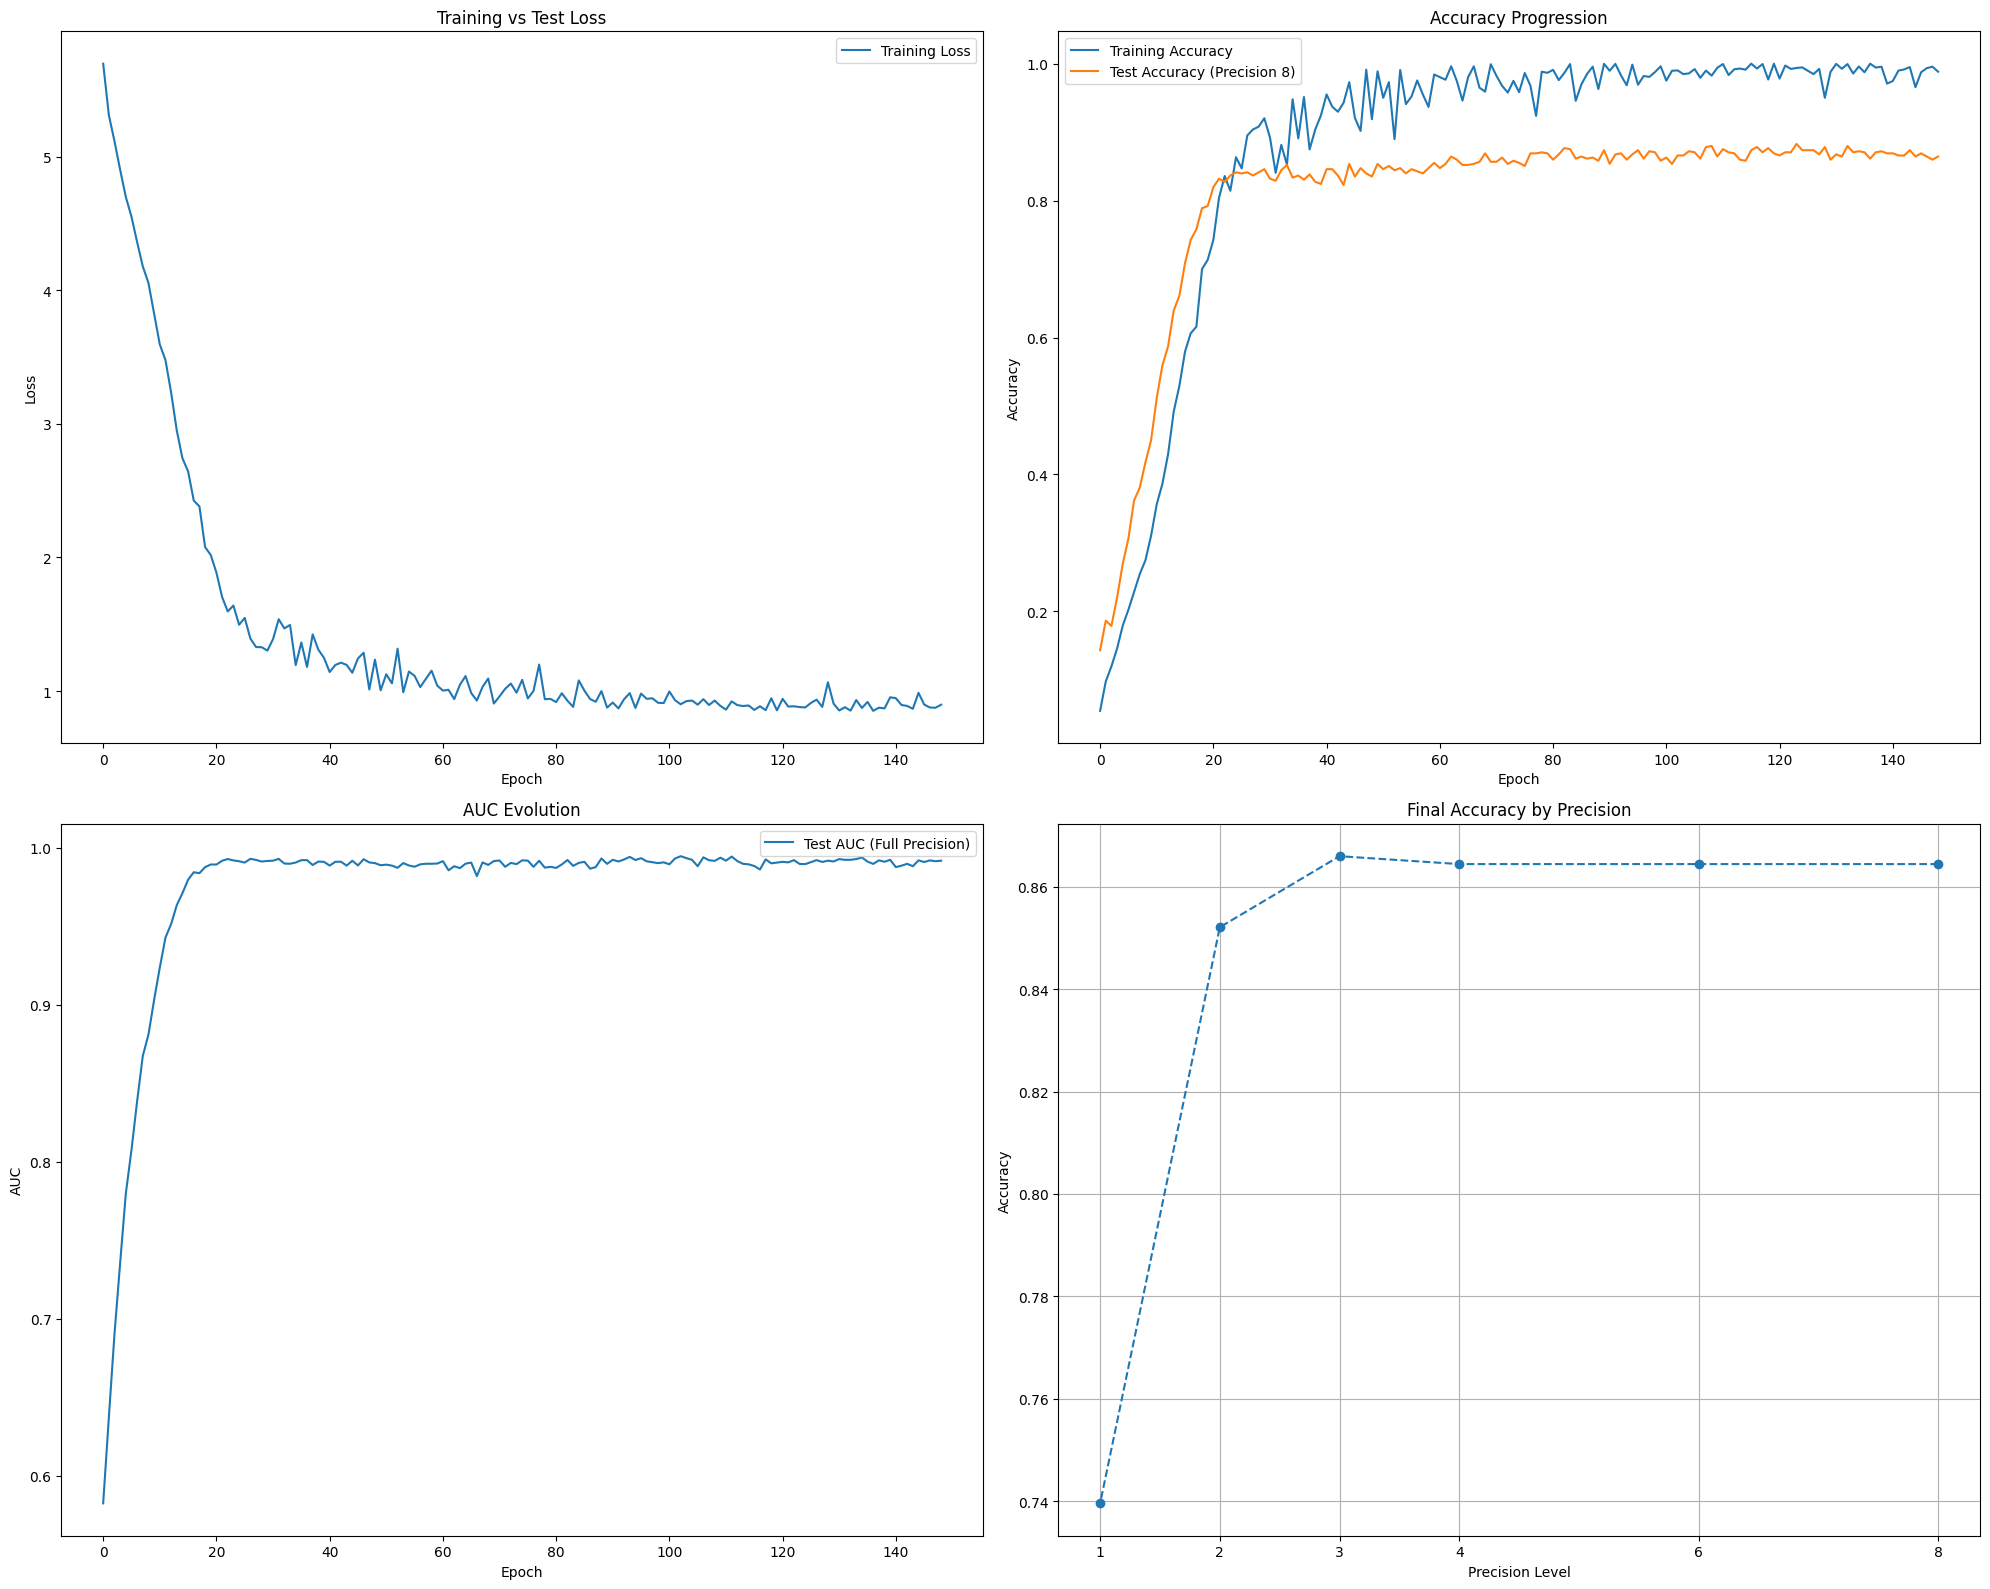


Final Evaluation Results:

Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       1.00      1.00      1.00         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.83      0.91       

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm import tqdm
import insightface
from insightface.app import FaceAnalysis
import albumentations as A
from torch.cuda.amp import autocast, GradScaler

# ======================
# Enhanced Configuration
# ======================
class Config:
    # Dataset parameters
    dataset_path = 'dataset/lfw-deepfunneled/lfw-deepfunneled'
    min_samples_per_class = 10
    test_size = 0.15
    random_state = 42
    
    # Model parameters
    embedding_dim = 512
    transformer_dim = 1024
    num_heads = 8
    num_layers = 4
    dropout_rate = 0.3
    
    # Training parameters
    batch_size = 256
    epochs = 200
    learning_rate = 3e-4
    weight_decay = 1e-4
    patience = 25
    label_smoothing = 0.1
    grad_clip = 1.0
    
    # Precision parameters
    precision_levels = [8, 6, 4, 3, 2, 1]
    noise_std = 0.2
    
    # Augmentation
    augment_prob = 0.8
    
    # System
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 0

# ======================
# Transformer-based Model
# ======================
class BiometricTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=1680):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=Config.num_heads,
            dim_feedforward=Config.transformer_dim,
            dropout=Config.dropout_rate,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, Config.num_layers)
        
        self.feature_enhancer = nn.Sequential(
            nn.Linear(input_dim, Config.transformer_dim),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim),
            nn.Dropout(Config.dropout_rate/2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(Config.transformer_dim, Config.transformer_dim//2),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim//2),
            nn.Dropout(Config.dropout_rate),
            nn.Linear(Config.transformer_dim//2, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.feature_enhancer(x)
        return self.classifier(x)

# ======================
# Enhanced Data Pipeline
# ======================
class BiometricDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.from_numpy(np.array(embeddings)).float()
        self.labels = torch.from_numpy(np.array(labels)).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2),
    A.ImageCompression(quality_lower=85, p=0.2)
])

def process_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
            
        if np.random.rand() < Config.augment_prob:
            img = augmentation(image=img)['image']
        
        img = cv2.resize(img, (112, 112))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

# ======================
# Optimized Precision Handling
# ======================
def simulate_fhe_effects(embeddings, decimals=3):
    scale = 10 ** decimals
    quantized = np.round(embeddings * scale) / scale
    noise = np.random.normal(0, Config.noise_std/(scale**0.5), embeddings.shape)
    return quantized + noise

# ======================
# Enhanced Training Loop
# ======================
def train_model(model, train_loader, test_loader, label_map):
    optimizer = optim.AdamW(model.parameters(), 
                          lr=Config.learning_rate, 
                          weight_decay=Config.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=Config.learning_rate*3,
        total_steps=Config.epochs*len(train_loader)
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
    scaler = GradScaler()
    
    best_acc = 0
    patience = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': {p: [] for p in Config.precision_levels},
        'test_loss': [],
        'test_auc': []
    }

    for epoch in range(Config.epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for emb, labels in pbar:
            if emb is None or labels is None:
                continue
                
            if np.random.rand() > 0.3:
                precision = np.random.choice(Config.precision_levels)
                if precision != Config.precision_levels[0]:
                    emb = simulate_fhe_effects(emb.numpy(), precision)
                    emb = torch.tensor(emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(emb)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'Loss': loss.item(), 'Acc': f"{correct/total:.2%}"})

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Full precision evaluation with loss and AUC
        model.eval()
        full_precision = Config.precision_levels[0]
        full_metrics = evaluate_model(model, test_loader, full_precision, label_map, criterion)
        
        history['test_loss'].append(full_metrics['loss'])
        history['test_auc'].append(full_metrics['auc'])
        history['test_acc'][full_precision].append(full_metrics['accuracy'])
        
        # Other precision evaluations
        epoch_accs = {full_precision: full_metrics['accuracy']}
        for precision in Config.precision_levels[1:]:
            metrics = evaluate_model(model, test_loader, precision, label_map)
            history['test_acc'][precision].append(metrics['accuracy'])
            epoch_accs[precision] = metrics['accuracy']

        if epoch_accs[full_precision] > best_acc:
            best_acc = epoch_accs[full_precision]
            torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else:
            patience += 1
            
        if patience >= Config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test Loss: {full_metrics['loss']:.4f} | Test AUC: {full_metrics['auc']:.4f}")
        for p, acc in epoch_accs.items():
            print(f"Precision {p}: Test Acc {acc:.2%}")
            
    return history

def evaluate_model(model, loader, precision, label_map, criterion=None):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0
    
    with torch.no_grad():
        for emb, labels in loader:
            if emb is None or labels is None:
                continue
                
            if precision < Config.precision_levels[0]:
                np_emb = emb.numpy()
                np_emb = simulate_fhe_effects(np_emb, precision)
                emb = torch.tensor(np_emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            outputs = model(emb)
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) if all_labels else 0
    loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    auc = 0
    
    try:
        if all_probs:
            auc = roc_auc_score(all_labels, np.concatenate(all_probs), 
                              multi_class='ovr', average='macro')
    except Exception as e:
        print(f"AUC calculation failed: {str(e)}")
    
    if precision == Config.precision_levels[0] and all_labels:
        print(f"\nClassification Report (Precision {precision}):")
        print(classification_report(all_labels, all_preds,
                                  target_names=[label_map[l] for l in np.unique(all_labels)],
                                  zero_division=0))
    
    return {'accuracy': accuracy, 'loss': loss, 'auc': auc}

# ======================
# Enhanced Visualization
# ======================
def plot_results(history):
    plt.figure(figsize=(20, 16))
    
    # Loss Curves
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    
    # Accuracy Progress
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    full_precision = Config.precision_levels[0]
    plt.plot(history['test_acc'][full_precision], 
            label=f'Test Accuracy (Precision {full_precision})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progression')
    plt.legend()
    
    # AUC Evolution
    plt.subplot(2, 2, 3)
    plt.plot(history['test_auc'], label='Test AUC (Full Precision)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Evolution')
    plt.legend()
    
    # Final Precision Accuracy
    plt.subplot(2, 2, 4)
    final_accuracies = [history['test_acc'][p][-1] for p in Config.precision_levels]
    plt.plot(Config.precision_levels, final_accuracies, marker='o', linestyle='--')
    plt.xlabel('Precision Level')
    plt.ylabel('Accuracy')
    plt.title('Final Accuracy by Precision')
    plt.xticks(Config.precision_levels)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ======================
# Execution Flow
# ======================
if __name__ == "__main__":
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(224, 224))
    
    # Dataset loading and processing (unchanged)
    identity_dict = {}
    for person in os.listdir(Config.dataset_path):
        person_dir = os.path.join(Config.dataset_path, person)
        if os.path.isdir(person_dir):
            images = [os.path.join(person_dir, f) for f in os.listdir(person_dir) 
                     if f.lower().endswith('.jpg')]
            if len(images) >= Config.min_samples_per_class:
                identity_dict[person] = images
                
    valid_identities = sorted([k for k, v in identity_dict.items() if len(v) >= Config.min_samples_per_class])
    name_to_label = {name: idx for idx, name in enumerate(valid_identities)}
    label_map = {v: k for k, v in name_to_label.items()}

    all_embeddings = []
    all_labels = []
    for person, images in identity_dict.items():
        if person not in valid_identities:
            continue
        label = name_to_label[person]
        for img_path in images:
            img = process_image(img_path)
            if img is None:
                continue
            embedding = app.models['recognition'].get_feat(img)
            embedding = embedding / np.linalg.norm(embedding)
            all_embeddings.append(embedding.astype(np.float32).ravel())
            all_labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        all_embeddings, all_labels, 
        test_size=max(Config.test_size, len(valid_identities)/len(all_labels)),
        stratify=all_labels,
        random_state=Config.random_state
    )
    
    train_loader = DataLoader(BiometricDataset(X_train, y_train), 
                            batch_size=Config.batch_size, 
                            shuffle=True, 
                            pin_memory=True)
    test_loader = DataLoader(BiometricDataset(X_test, y_test), 
                           batch_size=Config.batch_size, 
                           pin_memory=True)
    
    model = BiometricTransformer(
        input_dim=Config.embedding_dim,
        num_classes=len(valid_identities)
    ).to(Config.device)
    
    history = train_model(model, train_loader, test_loader, label_map)
    plot_results(history)
    
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nFinal Evaluation Results:")
    for precision in Config.precision_levels:
        metrics = evaluate_model(model, test_loader, precision, label_map)
        print(f"Precision {precision}: Acc={metrics['accuracy']:.2%} | AUC={metrics['auc']:.4f} | Loss={metrics['loss']:.4f}")
    
    # At the end of Part A's code:
    np.save('partA_train_embeddings.npy', X_train)
    np.save('partA_test_embeddings.npy', X_test)
    np.save('partA_train_labels.npy', y_train)
    np.save('partA_test_labels.npy', y_test)

=== Accuracy Metrics ===
Euclidean:
  Avg Difference: 1.25e-06
  Std Dev: 1.17e-07
  Max Difference: 1.44e-06

Cosine:
  Avg Difference: 1.76e-06
  Std Dev: 1.54e-07
  Max Difference: 2.01e-06

=== Runtime Metrics ===
Generation:
  Avg: 0.0000s
  Std Dev: 0.0000s

Encryption:
  Avg: 0.0089s
  Std Dev: 0.0006s

Computation:
  Avg: 0.3690s
  Std Dev: 0.0190s

Decryption:
  Avg: 0.0012s
  Std Dev: 0.0004s



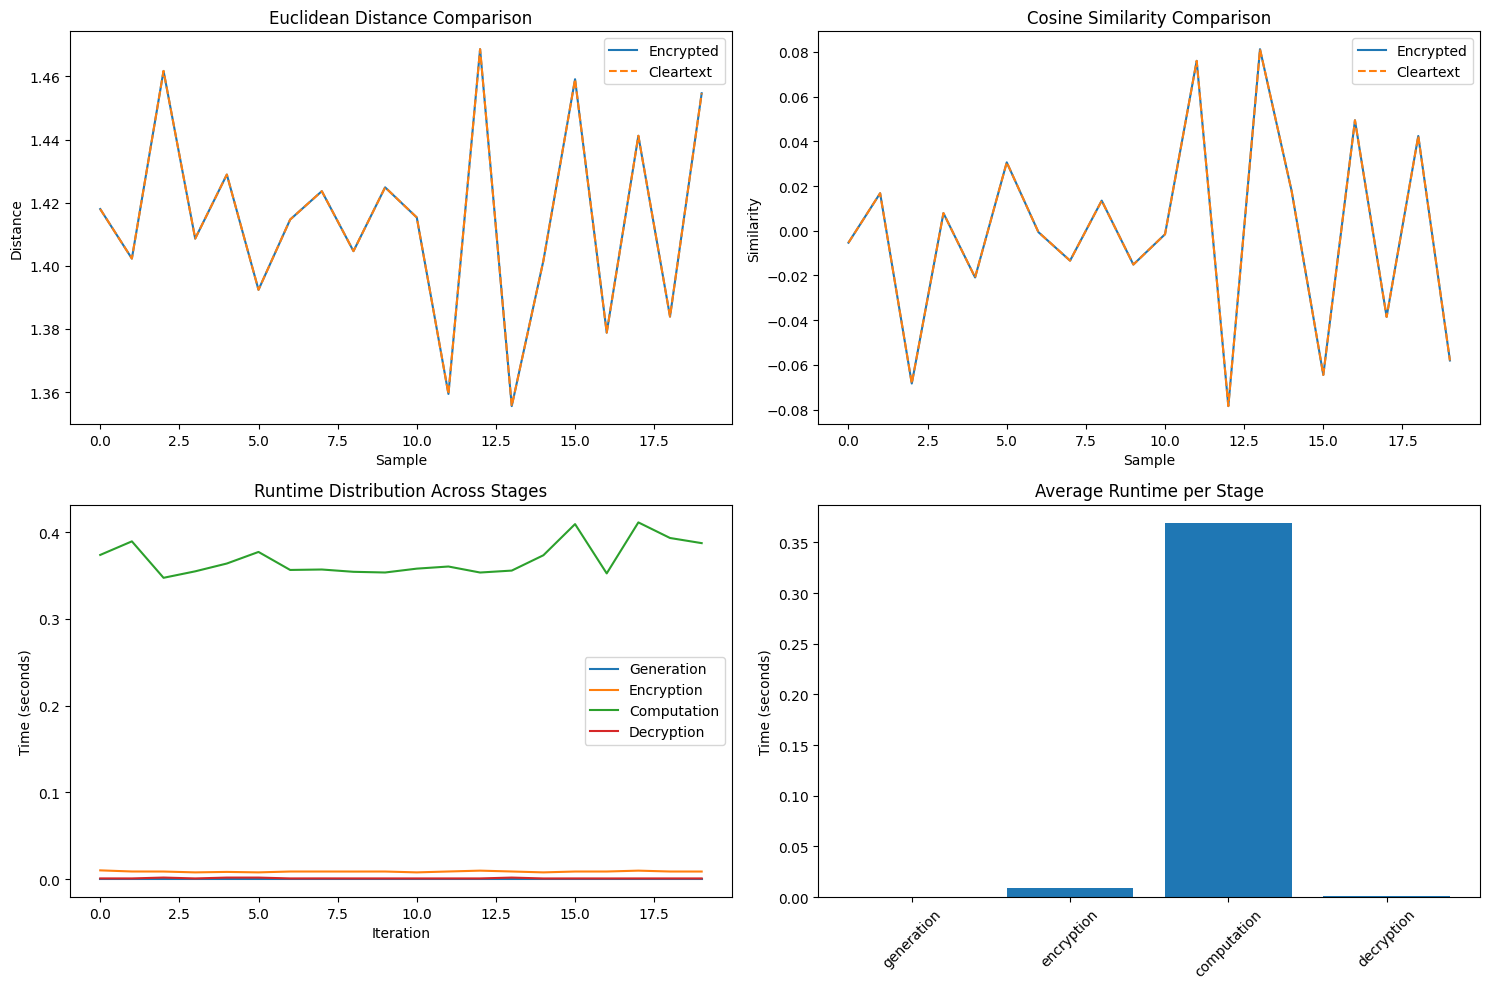


=== Final Demo ===
Euclidean Distance:
  Encrypted: 1.386083
  Cleartext: 1.386085
Cosine Similarity:
  Encrypted: 0.039386
  Cleartext: 0.039385


In [2]:
import time
import statistics
import numpy as np
import tenseal as ts
import matplotlib.pyplot as plt

# Configuration
VECTOR_DIM = 512
REPETITIONS = 20  # Reduced for practical testing
PLOT_SAMPLES = 50  # Number of samples to plot

# CKKS Context Setup
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2 ** 40

def generate_normalized_vector():
    """Generate random vector and normalize it"""
    vec = np.random.randn(VECTOR_DIM)
    return vec / np.linalg.norm(vec)

def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    """Compute cosine similarity for normalized vectors (dot product)"""
    return enc_vec1.dot(enc_vec2)

def homomorphic_euclidean_distance(enc_vec1, enc_vec2):
    """Compute squared Euclidean distance for normalized vectors (2 - 2*dot)"""
    dot_product = enc_vec1.dot(enc_vec2)
    return 2 - 2 * dot_product

# Data collection structures
metrics = {
    'euclidean': {'encrypted': [], 'cleartext': [], 'difference': []},
    'cosine': {'encrypted': [], 'cleartext': [], 'difference': []},
    'timing': {
        'generation': [],
        'encryption': [],
        'computation': [],
        'decryption': []
    }
}

# Main evaluation loop
for _ in range(REPETITIONS):
    # Vector generation and normalization
    t_start = time.time()
    vec1 = generate_normalized_vector()
    vec2 = generate_normalized_vector()
    metrics['timing']['generation'].append(time.time() - t_start)
    
    # Encryption
    t_start = time.time()
    enc_vec1 = ts.ckks_vector(context, vec1)
    enc_vec2 = ts.ckks_vector(context, vec2)
    metrics['timing']['encryption'].append(time.time() - t_start)
    
    # Homomorphic computations
    t_start = time.time()
    enc_euc = homomorphic_euclidean_distance(enc_vec1, enc_vec2)
    enc_cos = homomorphic_cosine_similarity(enc_vec1, enc_vec2)
    metrics['timing']['computation'].append(time.time() - t_start)
    
    # Decryption and cleartext comparison
    t_start = time.time()
    # Cleartext calculations
    clear_cos = np.dot(vec1, vec2)
    clear_euc = np.linalg.norm(vec1 - vec2)
    
    # Decrypt and process encrypted results
    decrypted_euc_sq = enc_euc.decrypt()[0]
    decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))  # Handle potential negative values from noise
    decrypted_cos = enc_cos.decrypt()[0]
    
    # Store metrics
    metrics['euclidean']['encrypted'].append(decrypted_euc)
    metrics['euclidean']['cleartext'].append(clear_euc)
    metrics['euclidean']['difference'].append(abs(decrypted_euc - clear_euc))
    
    metrics['cosine']['encrypted'].append(decrypted_cos)
    metrics['cosine']['cleartext'].append(clear_cos)
    metrics['cosine']['difference'].append(abs(decrypted_cos - clear_cos))
    metrics['timing']['decryption'].append(time.time() - t_start)

# Visualization functions
def plot_metrics():
    plt.figure(figsize=(15, 10))
    
    # Euclidean Distance Comparison
    plt.subplot(2, 2, 1)
    plt.plot(metrics['euclidean']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['euclidean']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Euclidean Distance Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Distance")
    plt.legend()
    
    # Cosine Similarity Comparison
    plt.subplot(2, 2, 2)
    plt.plot(metrics['cosine']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['cosine']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Cosine Similarity Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Similarity")
    plt.legend()
    
    # Runtime Distribution
    plt.subplot(2, 2, 3)
    for stage in ['generation', 'encryption', 'computation', 'decryption']:
        plt.plot(metrics['timing'][stage], label=stage.capitalize())
    plt.title("Runtime Distribution Across Stages")
    plt.xlabel("Iteration")
    plt.ylabel("Time (seconds)")
    plt.legend()
    
    # Average Runtime
    plt.subplot(2, 2, 4)
    avg_times = [statistics.mean(metrics['timing'][stage]) for stage in metrics['timing']]
    plt.bar(metrics['timing'].keys(), avg_times)
    plt.title("Average Runtime per Stage")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Generate and display results
print("=== Accuracy Metrics ===")
for metric in ['euclidean', 'cosine']:
    avg_diff = statistics.mean(metrics[metric]['difference'])
    std_diff = statistics.pstdev(metrics[metric]['difference']) if len(metrics[metric]['difference']) > 1 else 0
    max_diff = max(metrics[metric]['difference'])
    print(f"{metric.capitalize()}:\n  Avg Difference: {avg_diff:.2e}\n  Std Dev: {std_diff:.2e}\n  Max Difference: {max_diff:.2e}\n")

print("=== Runtime Metrics ===")
for stage in metrics['timing']:
    avg_time = statistics.mean(metrics['timing'][stage])
    std_time = statistics.pstdev(metrics['timing'][stage]) if len(metrics['timing'][stage]) > 1 else 0
    print(f"{stage.capitalize()}:\n  Avg: {avg_time:.4f}s\n  Std Dev: {std_time:.4f}s\n")

# Generate visualizations
plot_metrics()

# Final demo
print("\n=== Final Demo ===")
demo_vec1 = generate_normalized_vector()
demo_vec2 = generate_normalized_vector()
enc_demo1 = ts.ckks_vector(context, demo_vec1)
enc_demo2 = ts.ckks_vector(context, demo_vec2)

# Homomorphic computations
enc_euc = homomorphic_euclidean_distance(enc_demo1, enc_demo2)
enc_cos = homomorphic_cosine_similarity(enc_demo1, enc_demo2)

# Decryption and processing
decrypted_euc_sq = enc_euc.decrypt()[0]
decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))
decrypted_cos = enc_cos.decrypt()[0]

# Cleartext calculations
clear_euc = np.linalg.norm(demo_vec1 - demo_vec2)
clear_cos = np.dot(demo_vec1, demo_vec2)

print(f"Euclidean Distance:\n  Encrypted: {decrypted_euc:.6f}\n  Cleartext: {clear_euc:.6f}")
print(f"Cosine Similarity:\n  Encrypted: {decrypted_cos:.6f}\n  Cleartext: {clear_cos:.6f}")

Generating cleartext results...

Running homomorphic processing...
Processing sample 1/10
Processing sample 2/10
Processing sample 3/10
Processing sample 4/10
Processing sample 5/10
Processing sample 6/10
Processing sample 7/10
Processing sample 8/10
Processing sample 9/10
Processing sample 10/10

Calculating accuracy metrics...

=== Accuracy Results ===
Score Differences:
  Average: 6.21e-07
  Maximum: 1.14e-06
  Minimum: 9.35e-08
  Std Dev: 1.25e-07

Top-K Accuracy:
  Top-1: 100.00%
  Top-2: 100.00%
  Top-3: 100.00%
  Top-4: 100.00%
  Top-5: 100.00%
  Top-6: 100.00%
  Top-7: 100.00%
  Top-8: 100.00%
  Top-9: 100.00%
  Top-10: 100.00%

=== Performance Metrics ===
Encryption Time: 0.0052s/sample
Computation Time: 18.3907s/sample
Decryption Time: 0.9202s/sample
Total Time/Sample: 19.3162s
Ciphertext Size: 0.32MB


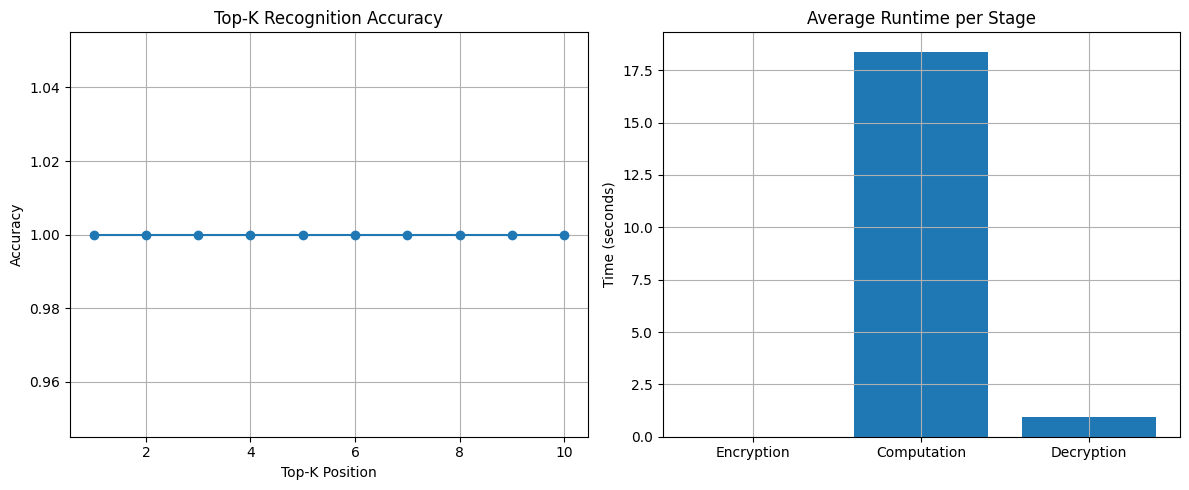

In [4]:
import time
import numpy as np
import pandas as pd
import tenseal as ts
from pathlib import Path
from sklearn.metrics import top_k_accuracy_score
import sys

# ======================
# Configuration
# ======================
VECTOR_DIM = 512
NUM_TEMPLATES = 1000  # Adjust based on your dataset
NUM_TEST_SAMPLES = 10  # Start with smaller numbers for testing
TOP_K = 10
CKKS_PARAMS = {
    "poly_modulus_degree": 8192,
    "coeff_mod_bit_sizes": [60, 40, 40, 60],
    "global_scale": 2**40
}

# ======================
# Data Loading
# ======================
X_train = np.load('partA_train_embeddings.npy')[:NUM_TEMPLATES]
X_test = np.load('partA_test_embeddings.npy')[:NUM_TEST_SAMPLES]
y_test = np.load('partA_test_labels.npy')[:NUM_TEST_SAMPLES]

# ======================
# Step 5-6: Cleartext Processing
# ======================
def generate_cleartext_results():
    print("Generating cleartext results...")
    
    # Compute similarity scores
    scores = np.dot(X_test, X_train.T)
    
    # Get top-K indices
    top10_indices = np.argsort(-scores, axis=1)[:, :TOP_K]
    
    # Save to CSV
    pd.DataFrame(scores).to_csv('scores.csv', index=False)
    pd.DataFrame(top10_indices).to_csv('top10.csv', index=False)
    
    return scores, top10_indices

cleartext_scores, cleartext_top10 = generate_cleartext_results()

# ======================
# Step 7-8: Homomorphic Processing
# ======================
class HomomorphicBiometricSystem:
    def __init__(self):
        self.context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=CKKS_PARAMS["poly_modulus_degree"],
            coeff_mod_bit_sizes=CKKS_PARAMS["coeff_mod_bit_sizes"]
        )
        self.context.generate_galois_keys()
        self.context.global_scale = CKKS_PARAMS["global_scale"]
        
        # Encrypt templates with SIMD packing
        self.encrypted_templates = self._batch_encrypt(X_train)
        
    def _batch_encrypt(self, vectors):
        """Encrypt vectors using SIMD packing"""
        encrypted = []
        for vec in vectors:
            # Normalize and encrypt
            vec_norm = vec / np.linalg.norm(vec)
            enc = ts.ckks_vector(self.context, vec_norm)
            encrypted.append(enc)
        return encrypted
    
    def process_sample(self, sample):
        """Process one sample through homomorphic pipeline"""
        # Encrypt sample
        t_start = time.time()
        sample_norm = sample / np.linalg.norm(sample)
        enc_sample = ts.ckks_vector(self.context, sample_norm)
        encrypt_time = time.time() - t_start
        
        # Compute similarities
        t_start = time.time()
        similarities = [enc_sample.dot(t) for t in self.encrypted_templates]
        compute_time = time.time() - t_start
        
        # Decrypt results
        t_start = time.time()
        decrypted = np.array([s.decrypt()[0] for s in similarities])
        decrypt_time = time.time() - t_start
        
        return {
            'scores': decrypted,
            'timing': (encrypt_time, compute_time, decrypt_time)
        }

# ======================
# Main Processing
# ======================
def homomorphic_processing():
    print("\nRunning homomorphic processing...")
    system = HomomorphicBiometricSystem()
    
    # Storage for results
    homomorphic_scores = []
    homomorphic_top10 = []
    timing_metrics = {
        'encryption': [],
        'computation': [],
        'decryption': []
    }
    
    for idx, sample in enumerate(X_test):
        print(f"Processing sample {idx+1}/{len(X_test)}")
        result = system.process_sample(sample)
        
        # Store results
        homomorphic_scores.append(result['scores'])
        homomorphic_top10.append(np.argsort(-result['scores'])[:TOP_K])
        
        # Store timings
        t_enc, t_comp, t_dec = result['timing']
        timing_metrics['encryption'].append(t_enc)
        timing_metrics['computation'].append(t_comp)
        timing_metrics['decryption'].append(t_dec)
    
    # Save results
    pd.DataFrame(homomorphic_scores).to_csv('scores_dec.csv', index=False)
    pd.DataFrame(homomorphic_top10).to_csv('top10_dec.csv', index=False)
    
    return homomorphic_scores, homomorphic_top10, timing_metrics

hom_scores, hom_top10, timings = homomorphic_processing()

# ======================
# Step 9-10: Accuracy Measurement
# ======================
def calculate_accuracy():
    print("\nCalculating accuracy metrics...")
    
    # Convert lists to numpy arrays
    cleartext_top10_arr = np.array(cleartext_top10)
    hom_top10_arr = np.array(hom_top10)

    # Score comparisons
    score_diffs = np.abs(cleartext_scores - np.array(hom_scores))
    score_metrics = {
        'avg_diff': np.mean(score_diffs),
        'max_diff': np.max(score_diffs),
        'min_diff': np.min(score_diffs),
        'std_diff': np.std(score_diffs)
    }
    
    # Top-K accuracy
    topk_accuracies = []
    for k in range(TOP_K):
        matches = np.sum(cleartext_top10_arr[:, k] == hom_top10_arr[:, k])
        topk_accuracies.append(matches / len(X_test))
    
    return score_metrics, topk_accuracies

score_metrics, topk_acc = calculate_accuracy()

# ======================
# Step 11-12: Performance Metrics
# ======================
def calculate_performance(timings):
    # Runtime metrics
    perf_metrics = {
        'encryption_avg': np.mean(timings['encryption']),
        'computation_avg': np.mean(timings['computation']),
        'decryption_avg': np.mean(timings['decryption']),
        'total_avg': np.sum([np.mean(timings[k]) for k in timings])
    }
    
    # Ciphertext size measurement (fix system reference)
    dummy_ct = ts.ckks_vector(HomomorphicBiometricSystem().context, X_test[0]).serialize()
    perf_metrics['ciphertext_size'] = len(dummy_ct) / (1024 * 1024)  # in MB
    
    return perf_metrics

perf_metrics = calculate_performance(timings)

# ======================
# Reporting
# ======================
print("\n=== Accuracy Results ===")
print(f"Score Differences:")
print(f"  Average: {score_metrics['avg_diff']:.2e}")
print(f"  Maximum: {score_metrics['max_diff']:.2e}")
print(f"  Minimum: {score_metrics['min_diff']:.2e}")
print(f"  Std Dev: {score_metrics['std_diff']:.2e}")

print("\nTop-K Accuracy:")
for k, acc in enumerate(topk_acc):
    print(f"  Top-{k+1}: {acc:.2%}")

print("\n=== Performance Metrics ===")
print(f"Encryption Time: {perf_metrics['encryption_avg']:.4f}s/sample")
print(f"Computation Time: {perf_metrics['computation_avg']:.4f}s/sample")
print(f"Decryption Time: {perf_metrics['decryption_avg']:.4f}s/sample")
print(f"Total Time/Sample: {perf_metrics['total_avg']:.4f}s")
print(f"Ciphertext Size: {perf_metrics['ciphertext_size']:.2f}MB")

# ======================
# Visualization
# ======================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, TOP_K+1), topk_acc, marker='o')
plt.xlabel('Top-K Position')
plt.ylabel('Accuracy')
plt.title('Top-K Recognition Accuracy')
plt.grid(True)

# Runtime Plot
plt.subplot(1, 2, 2)
plt.bar(['Encryption', 'Computation', 'Decryption'], 
        [perf_metrics['encryption_avg'], 
         perf_metrics['computation_avg'], 
         perf_metrics['decryption_avg']])
plt.ylabel('Time (seconds)')
plt.title('Average Runtime per Stage')
plt.grid(True)

plt.tight_layout()
plt.show()